In [4]:
!unzip /content/l.zip -d /content/

Archive:  /content/l.zip
   creating: /content/new disease/
   creating: /content/new disease/Alopecia_Areata/
  inflating: /content/new disease/Alopecia_Areata/1200px-Allopecia_areata_jpg.rf.52f899df58210616888f417f6ae79afa.jpg  
  inflating: /content/new disease/Alopecia_Areata/1200px-Allopecia_areata_jpg.rf.63e44bce74282ca947b3f771516636b8.jpg  
  inflating: /content/new disease/Alopecia_Areata/1200px-Allopecia_areata_jpg.rf.a35e68eecb79c686d468d462b167bd07.jpg  
  inflating: /content/new disease/Alopecia_Areata/1320_jpg.rf.3f97560eff20689eb8acc8b7e1390338.jpg  
  inflating: /content/new disease/Alopecia_Areata/1320_jpg.rf.a4d11b24250f436a3d2b476dce1f315b.jpg  
  inflating: /content/new disease/Alopecia_Areata/1320_jpg.rf.d5bad1ffafabd05e36c7aa012a3d95ca.jpg  
  inflating: /content/new disease/Alopecia_Areata/1320__WatermarkedWyJXYXRlcm1hcmtlZCJd.jpg  
  inflating: /content/new disease/Alopecia_Areata/1321_jpg.rf.bc85bfc93862150c7d329ee00dd998d7.jpg  
  inflating: /content/new disea

In [5]:
pip install split-folders

In [6]:
import splitfolders

# Path to your dataset
input_folder = "//content/new disease"

# Output directory where split folders will be stored
output_folder = "/content/output_split_dataset"

# Split ratio: 80% train, 10% val, 10% test
splitfolders.ratio(input_folder, output=output_folder, seed=1337, ratio=(.7, .2, .1), move=False)


Copying files: 1744 files [00:00, 6954.06 files/s]


Found 1219 images belonging to 2 classes.
Found 348 images belonging to 2 classes.
94668760/94668760 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
51877672/51877672 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/50
153/153 ━━━━━━━━━━━━━━━━━━━━ 675s 2s/step - accuracy: 0.7801 - loss: 6.3974 - val_accuracy: 0.9282 - val_loss: 4.7536 - learning_rate: 1.0000e-04
Epoch 2/50
153/153 ━━━━━━━━━━━━━━━━━━━━ 38s 248ms/step - accuracy: 0.9283 - loss: 4.4598 - val_accuracy: 0.9655 - val_loss: 3.6951 - learning_rate: 1.0000e-04
Epoch 3/50
153/153 ━━━━━━━━━━━━━━━━━━━━ 40s 244ms/step - accuracy: 0.9042 - loss: 3.6417 - val_accuracy: 0.9425 - val_loss: 3.1904 - learning_rate: 1.0000e-04
Epoch 4/50
153/153 ━━━━━━━━━━━━━━━━━━━━ 38s 246ms/step - accuracy: 0.9475 - loss: 3.0271 - val_accuracy: 0.9626 - val_loss: 2.6327 - learning_rate: 1.0000e-04
Epoch 5/50
153/153 ━━━━━━━━━━━━━━━━━━━━ 38s 245ms/step - accuracy: 0.9597 - loss: 2.5890 - val_accuracy: 0.9741 - val_loss: 2.2457 - learning_rate: 1.0000e-04
Epoch 6/50
153/153 ━━━━━━━━━━━━━━━━━━━━ 37s 244ms/step - accuracy: 0.9612 - loss: 2.1956 - val_accuracy: 0.9626 - val_loss: 1.9551 - learning_rate: 1.0000e-04
Epoch 7/50
153/153 ━━━━━━━━━━━━━━━━━━━━ 38s 245m

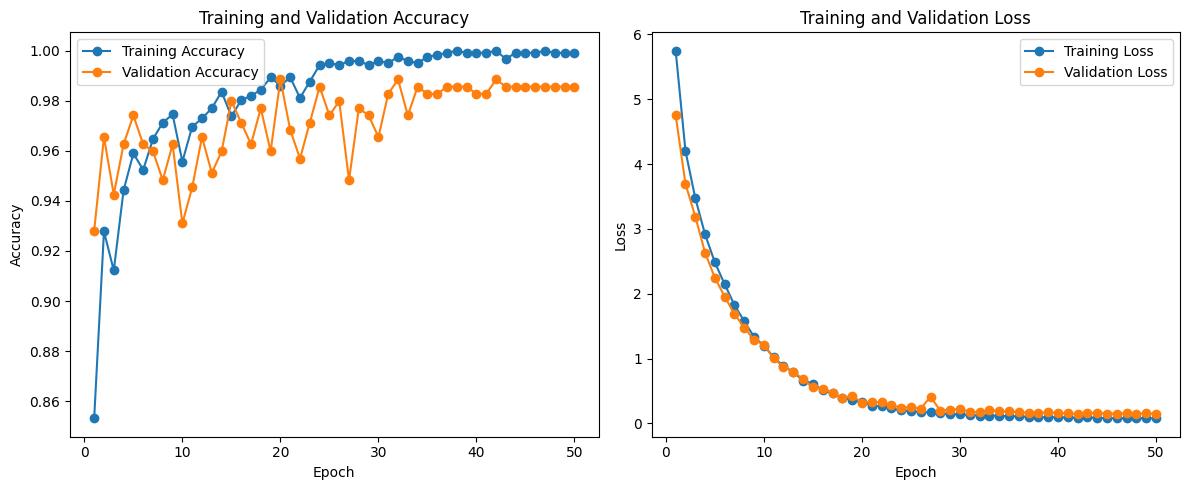

Saved model weights to /content/new disease/final_model_weights.weights.h5


In [7]:
import os
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.applications import ResNet50V2, DenseNet169
from tensorflow.keras.layers import Input, Concatenate, Dense, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.regularizers import l2
import tensorflow as tf

# ================================
# 1. Set Random Seeds for Reproducibility
# ================================
SEED = 42
tf.random.set_seed(SEED)
np.random.seed(SEED)

# ================================
# 2. Define Constants and Paths
# ================================
INPUT_SHAPE = (224, 224, 3)
BATCH_SIZE = 8  # Smaller batch size for better generalization
NUM_CLASSES = 2
EPOCHS = 50
INITIAL_LR = 1e-4  # Reduced initial learning rate to avoid large initial loss
TRAIN_DIR = '//content/output_split_dataset/train'
VALID_DIR = '//content/output_split_dataset/val'
DRIVE_MODEL_PATH = '/content/new disease'

# Ensure the directory exists for saving outputs
os.makedirs(DRIVE_MODEL_PATH, exist_ok=True)

# ================================
# 3. Create Data Generators with Augmentation
# ================================
datagen_train = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

datagen_val = ImageDataGenerator(rescale=1./255)

train_generator = datagen_train.flow_from_directory(
    TRAIN_DIR,
    target_size=INPUT_SHAPE[:2],
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=True,
    seed=SEED
)

valid_generator = datagen_val.flow_from_directory(
    VALID_DIR,
    target_size=INPUT_SHAPE[:2],
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)

# ================================
# 4. Build a Simplified Multi-Branch Model with Moderate Regularization
# ================================

def build_model():
    inputs = Input(shape=INPUT_SHAPE, name="main_input")

    # Instantiate only two base models to reduce complexity
    resnet_base = ResNet50V2(weights='imagenet', include_top=False, pooling='avg', name='resnet_base')
    densenet_base = DenseNet169(weights='imagenet', include_top=False, pooling='avg', name='densenet_base')

    # Pass the input through each model independently
    resnet_out = resnet_base(inputs)
    densenet_out = densenet_base(inputs)

    # Concatenate the outputs of the models
    combined = Concatenate(name='concatenate')([resnet_out, densenet_out])

    # Add fully connected layers with reduced L2 regularization and dropout
    x = Dense(256, activation='relu', kernel_regularizer=l2(0.01), name='fc1')(combined)
    x = Dropout(0.5, name='dropout1')(x)  # Moderate dropout rate
    x = Dense(128, activation='relu', kernel_regularizer=l2(0.01), name='fc2')(x)
    x = Dropout(0.5, name='dropout2')(x)

    output = Dense(NUM_CLASSES, activation='softmax', name='output')(x)

    # Define inputs and outputs in the final model
    model = Model(inputs=inputs, outputs=output, name='RegularizedMultiBranchModel')
    return model

# Build and compile the model
model = build_model()
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=INITIAL_LR),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# ================================
# 5. Training with Early Stopping and Learning Rate Reduction
# ================================
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True,
    verbose=1
)

# Learning rate reduction on plateau
lr_reduction = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=2,
    min_lr=1e-6,
    verbose=1
)

history = model.fit(
    train_generator,
    epochs=EPOCHS,
    validation_data=valid_generator,
    callbacks=[early_stopping, lr_reduction],
    verbose=1
)

# ================================
# Plot Training and Validation Accuracy and Loss
# ================================

def plot_training_history(history):
    epochs = range(1, len(history.history['accuracy']) + 1)
    train_acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    train_loss = history.history['loss']
    val_loss = history.history['val_loss']

    plt.figure(figsize=(12, 5))

    # Plot Accuracy
    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_acc, label="Training Accuracy", marker='o')
    plt.plot(epochs, val_acc, label="Validation Accuracy", marker='o')
    plt.title("Training and Validation Accuracy")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.legend()

    # Plot Loss
    plt.subplot(1, 2, 2)
    plt.plot(epochs, train_loss, label="Training Loss", marker='o')
    plt.plot(epochs, val_loss, label="Validation Loss", marker='o')
    plt.title("Training and Validation Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()

    plt.tight_layout()
    plt.show()

# Plot the training history
plot_training_history(history)

# ================================
# Save the Model Weights
# ================================
model.save(os.path.join(DRIVE_MODEL_PATH, 'final_model_weights.weights.keras'))
print(f'Saved model weights to {os.path.join(DRIVE_MODEL_PATH, "final_model_weights.weights.h5")}')

44/44 ━━━━━━━━━━━━━━━━━━━━ 46s 567ms/step
Classification Report:
                       precision    recall  f1-score   support

      Alopecia_Areata       0.99      0.99      0.99       295
Androgenetic_Alopecia       0.96      0.96      0.96        53

             accuracy                           0.99       348
            macro avg       0.98      0.98      0.98       348
         weighted avg       0.99      0.99      0.99       348

Confusion Matrix:
[[293   2]
 [  2  51]]


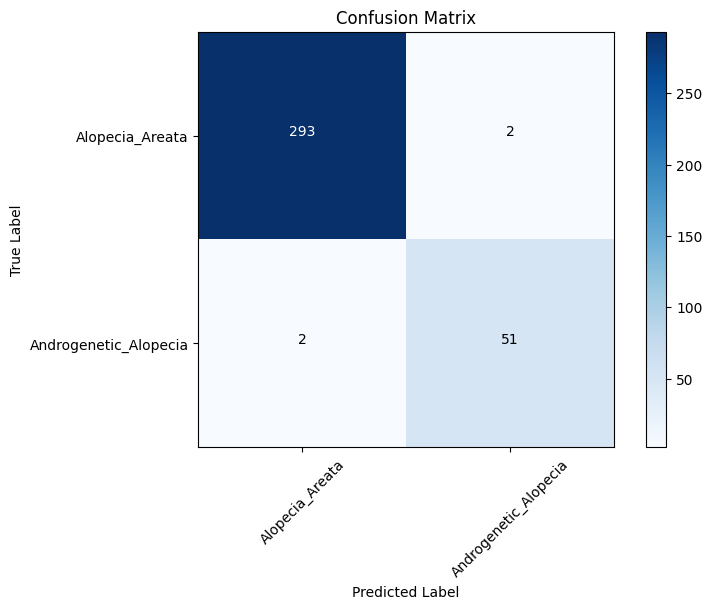

In [8]:
# Reset the validation generator to ensure we start from the first batch
valid_generator.reset()

# Compute steps as an integer
steps = int(np.ceil(valid_generator.samples / valid_generator.batch_size))

# Generate predictions for the entire validation set.
predictions = model.predict(valid_generator, steps=steps)
y_pred = np.argmax(predictions, axis=1)
y_true = valid_generator.classes

# Get the class labels using the class_indices dictionary of the generator.
target_names = [k for k, v in sorted(valid_generator.class_indices.items(), key=lambda item: item[1])]

# Print the classification report.
from sklearn.metrics import classification_report, confusion_matrix
print("Classification Report:")
print(classification_report(y_true, y_pred, target_names=target_names))

# Compute the confusion matrix.
cm = confusion_matrix(y_true, y_pred)
print("Confusion Matrix:")
print(cm)

# Function to plot the confusion matrix using matplotlib.
def plot_confusion_matrix(cm, classes):
    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title("Confusion Matrix")
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    # Add numbers in each cell
    thresh = cm.max() / 2.0
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            plt.text(j, i, format(cm[i, j], 'd'),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel("True Label")
    plt.xlabel("Predicted Label")
    plt.show()

# Plot the confusion matrix.
plot_confusion_matrix(cm, target_names)


In [ ]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.models import load_model
import matplotlib.pyplot as plt

# ================================
# 1. Load the Trained Model
# ================================
MODEL_PATH = "/content/new disease/final_model_weights.weights.keras"  # Update with your .keras file path
model = load_model(MODEL_PATH)
print("Model loaded successfully.")

# ================================
# 2. Define Image Preprocessing Function
# ================================
def preprocess_image(image_path, target_size=(224, 224)):
    """
    Preprocesses an image for prediction.

    Parameters:
        image_path (str): Path to the image file.
        target_size (tuple): Target size for resizing the image.

    Returns:
        np.ndarray: Preprocessed image.
    """
    # Load the image
    img = load_img(image_path, target_size=target_size)
    # Convert image to numpy array
    img_array = img_to_array(img)
    # Scale pixel values to [0, 1]
    img_array = img_array / 255.0
    # Add batch dimension
    img_array = np.expand_dims(img_array, axis=0)
    return img_array

# ================================
# 3. Make Predictions
# ================================
def predict_image(image_path, model, class_names):
    """
    Predicts the class of an input image.

    Parameters:
        image_path (str): Path to the image.
        model (tf.keras.Model): Trained Keras model.
        class_names (list): List of class names corresponding to the model's output.

    Returns:
        None: Prints the predicted class and confidence.
    """
    # Preprocess the image
    preprocessed_image = preprocess_image(image_path)

    # Predict the class
    predictions = model.predict(preprocessed_image)
    predicted_class_index = np.argmax(predictions, axis=1)[0]
    confidence = predictions[0][predicted_class_index]

    # Display the result
    print(f"Image: {image_path}")
    print(f"Predicted Class: {class_names[predicted_class_index]} (Confidence: {confidence:.2f})")

    # Show the image
    img = load_img(image_path)
    plt.imshow(img)
    plt.title(f"Predicted: {class_names[predicted_class_index]} (Conf: {confidence:.2f})")
    plt.axis('off')
    plt.show()

# ================================
# 4. Predict on a Single Image
# ================================
# Define class names (replace with the names corresponding to your dataset)
class_names = ['Alopecia_Areata', 'Androgenetic_Alopecia']

# Path to the image file

image_path = "/content/images (4).jpg"

# Predict the image
predict_image(image_path, model, class_names)


Model loaded successfully.
